<a href="https://colab.research.google.com/github/AchmadRifqyPratama/Bi-LSTM-BP/blob/main/Bi_LSTM_BP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
import csv
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, Bidirectional
import scipy.io  # to load MAT files
from matplotlib import pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
import sys
import scipy.signal as signal # to downsample input data
from scipy.signal import find_peaks, peak_prominences
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
import scipy.stats

# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')
working_dir = '/content/drive/My Drive/KP PT Xirka/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data cleaning and segmentation per subject**

In [ ]:
dataset = {}
dataset_dir = working_dir + '/dataset_MIMIC/Samples'
for segment in range(1,501):
  data_subj = "data_%d" % segment
  dataset[data_subj] = np.empty((0, 3))
  with open(f'{dataset_dir}/rec_{segment}.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    rows = []
    for row in csv_reader:
      rows.append(row)
    rows = np.array(rows)
    rowss = np.transpose(rows)
    rowsss = rowss.astype('float32')
  csv_file.close()
  dataset[data_subj] = np.append(dataset[data_subj], rowsss, axis=0)

In [ ]:
fs = 125
window = 10*fs
overlap = 5*fs

In [ ]:
def create_data_windowing(data_raw_ABP, data_filtered_and_normalized_PPG, window, overlap):
  ABP_reshape = np.reshape(data_raw_ABP, (data_raw_ABP.shape[0], 1))
  data = np.empty((0, window, 2))
  fusion_PPG = np.reshape(data_filtered_and_normalized_PPG, (data_filtered_and_normalized_PPG.shape[0], 1))
  fusion_ABP = ABP_reshape[bias_filter:]
  fusion = np.hstack((fusion_PPG, fusion_ABP))
  i = 0
  num_w = 0
  while i + window  <= len(fusion):
    i += (window - overlap)
    num_w += 1
  # compute actual windows
  data_part = np.empty((num_w, window, 2))  # preallocate
  i = 0
  for w in range(0, num_w):
    data_part[w] = fusion[i:i + window]
    i += (window - overlap)
  data = np.vstack((data, data_part))
  return data

In [ ]:
def peak_PPG(filtered_signal):
  peaks_norm, _ = find_peaks(filtered_signal, height=0)
  peaks_norm1, _ = find_peaks(filtered_signal, distance=48)
  _, peaks_norm_idx_intersect, _ = np.intersect1d(peaks_norm, peaks_norm1, return_indices=True)
  peaks_norm2 = np.delete(peaks_norm, peaks_norm_idx_intersect)
  sys_peak_PPG = filtered_signal[peaks_norm1]
  dia_peak_PPG = filtered_signal[peaks_norm2]
  return peaks_norm1, peaks_norm2, sys_peak_PPG, dia_peak_PPG

In [ ]:
def peak_ABP(raw_signal):
  peaks_ABP1, _ = find_peaks(raw_signal, height=(90, 180))
  peaks_ABP2, _ = find_peaks(-raw_signal, height=(-110, -50))
  SBP = raw_signal[peaks_ABP1]
  DBP = raw_signal[peaks_ABP2]
  return peaks_ABP1, peaks_ABP2, SBP, DBP

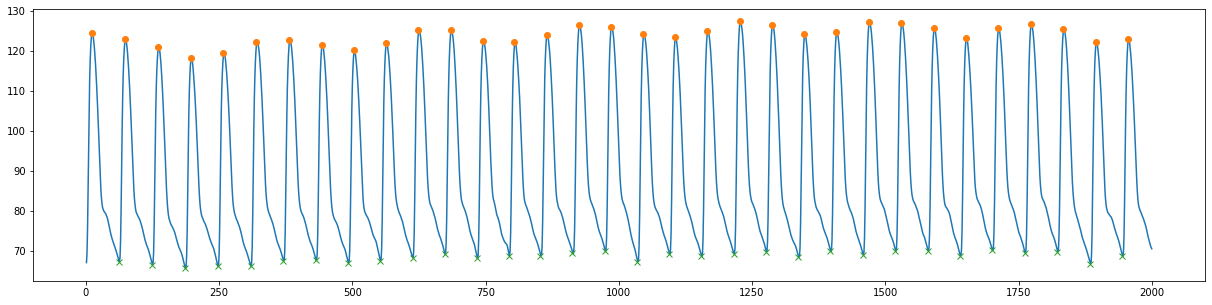

In [148]:
widthpeaks_sys, widthpeaks_dia, sys_peak, dia_peak = peak_ABP(dataset["data_1"][0:2000, 1])
f = plt.figure()
f.set_figwidth(21)
f.set_figheight(5)
plt.plot(np.arange(1, 2000+1), dataset["data_1"][0:2000, 1])
plt.plot(widthpeaks_sys, sys_peak, "o")
plt.plot(widthpeaks_dia, dia_peak, "x")
plt.show()

In [ ]:
dataset["data_1"][0:2000]

array([[ 1.75950003e+00,  6.70630035e+01, -6.06059991e-02],
       [ 1.71850002e+00,  6.93590012e+01, -7.52689987e-02],
       [ 1.68429995e+00,  7.53659973e+01, -7.03810006e-02],
       ...,
       [ 2.59629989e+00,  7.11169968e+01,  1.54939994e-01],
       [ 2.51519990e+00,  7.08730011e+01,  1.49560004e-01],
       [ 2.43300009e+00,  7.05309982e+01,  1.44669995e-01]])

**SBP & DBP extraction from ABP and feature extraction from PPG**

In [ ]:
features_set = {}
bias_filter = 125

for segment in range(1,501):
  op_file_subj = dataset["data_%d" % segment]
  PPG = op_file_subj[0:len(op_file_subj), 0]
  ABP = op_file_subj[0:len(op_file_subj), 1]
  ECG = op_file_subj[0:len(op_file_subj), 2]

  # Filter data agar dicrotic notch lebih jelas
  sos = signal.cheby2(4, 10, [0.5, 5], 'bandpass', output='sos', fs=125)
  filtered_PPG = signal.sosfilt(sos, PPG)

  # Normalisasi data agar lebih mudah dideteksi puncaknya
  filtered_normalize = (filtered_PPG[bias_filter:] - filtered_PPG[bias_filter:].min()) / (filtered_PPG[bias_filter:].max() - filtered_PPG[bias_filter:].min())

  # Data windowing
  op_data_subj = create_data_windowing(ABP, filtered_normalize, window, overlap)

  # Featured Extraction
  features_arr_name = "op_data_subj_features_%d" % segment
  features_set[features_arr_name] = []

  data_featured = []
  energy_PPG_arr = []
  idx_sys_PPG_arr = []
  idx_dia_PPG_arr = []
  sys_PPG_arr = []
  dia_PPG_arr = []
  sys_ABP_arr = []
  dia_ABP_arr = []

  for ax in op_data_subj:
    idx_sys_peak_PPG, idx_dia_peak_PPG, sys_peak_PPG, dia_peak_PPG = peak_PPG(ax[:, 0])
    _ , _ , sys_peak_ABP, dia_peak_ABP = peak_ABP(ax[:, 1])

    energy_PPG = (np.sqrt(np.sum(np.square(ax[:, 0]))))/len(ax[:, 0])
    idx_sys_peak_PPG_med = np.median(np.diff(idx_sys_peak_PPG))
    idx_dia_peak_PPG_med = np.median(np.diff(idx_dia_peak_PPG))
    sys_peak_PPG_med = np.median(sys_peak_PPG)
    dia_peak_PPG_med = np.median(dia_peak_PPG)
    sys_peak_ABP_med = np.median(sys_peak_ABP)
    dia_peak_ABP_med = np.median(dia_peak_ABP)

    if ((len(sys_peak_PPG) != 0) and (len(dia_peak_PPG) != 0) and (len(dia_peak_PPG) == len(sys_peak_PPG)) and (np.isnan(dia_peak_ABP_med) == False) and (np.isnan(sys_peak_ABP_med) == False)):
      energy_PPG_arr.append(energy_PPG)
      idx_sys_PPG_arr.append(idx_sys_peak_PPG_med)
      idx_dia_PPG_arr.append(idx_dia_peak_PPG_med)
      sys_PPG_arr.append(sys_peak_PPG_med)
      dia_PPG_arr.append(dia_peak_PPG_med)
      sys_ABP_arr.append(sys_peak_ABP_med)
      dia_ABP_arr.append(dia_peak_ABP_med)

  # convert to numpy array
  energy_PPG_arr = np.array(energy_PPG_arr)
  idx_sys_PPG_arr = np.array(idx_sys_PPG_arr)
  idx_dia_PPG_arr = np.array(idx_dia_PPG_arr)
  sys_PPG_arr = np.array(sys_PPG_arr)
  dia_PPG_arr = np.array(dia_PPG_arr)
  sys_ABP_arr = np.array(sys_ABP_arr)
  dia_ABP_arr = np.array(dia_ABP_arr)

  data_featured.append(energy_PPG_arr)
  data_featured.append(idx_sys_PPG_arr)
  data_featured.append(idx_dia_PPG_arr)
  data_featured.append(sys_PPG_arr)
  data_featured.append(dia_PPG_arr)
  data_featured.append(sys_ABP_arr)
  data_featured.append(dia_ABP_arr)

  data_featured_arr = np.array(data_featured)
  features_set[features_arr_name] = np.transpose(data_featured_arr)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


**Input feature concatenation across subjects**

In [ ]:
baris = 0
for rjkl in range(1,501):
  namaewa = "op_data_subj_features_%d" % rjkl
  if len(features_set[namaewa]) != 0:
    baris = baris + len(features_set[namaewa])
baris

2285

In [143]:
input_data = np.empty((0, 7))
for segment in range(1,501):
  nama_data_subj = "op_data_subj_features_%d" % segment
  if len(features_set[nama_data_subj]) != 0:
    input_data = np.concatenate((input_data, features_set[nama_data_subj]), axis=0)
input_data

array([[1.51211278e-02, 6.10000000e+01, 6.10000000e+01, ...,
        3.90857970e-01, 1.25360001e+02, 6.91630020e+01],
       [1.50061254e-02, 6.10000000e+01, 6.10000000e+01, ...,
        3.94609010e-01, 1.27830002e+02, 7.10680008e+01],
       [1.51134743e-02, 6.10000000e+01, 6.10000000e+01, ...,
        4.18691658e-01, 1.27190002e+02, 6.97490005e+01],
       ...,
       [1.22624279e-02, 8.05000000e+01, 8.00000000e+01, ...,
        2.58213149e-01, 1.48759995e+02, 9.31360016e+01],
       [1.20591812e-02, 8.05000000e+01, 8.10000000e+01, ...,
        2.58088336e-01, 1.51690002e+02, 9.53050003e+01],
       [1.55981570e-02, 8.20000000e+01, 8.20000000e+01, ...,
        4.10815770e-01, 1.30940002e+02, 5.14029999e+01]])

<function matplotlib.pyplot.show>

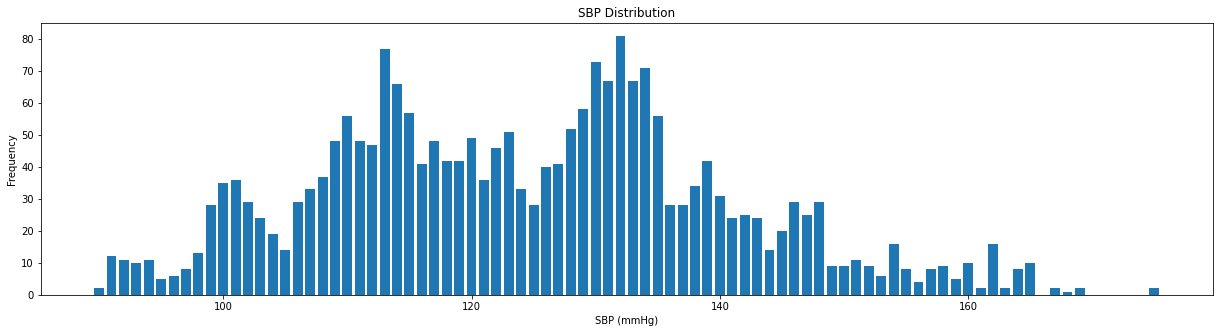

In [150]:
unique, frequency = np.unique(np.round(input_data[:, 5]).astype(int), 
                              return_counts = True) 
  
count = np.asarray((unique,frequency )).T

f1 = plt.figure()
f1.set_figwidth(21)
f1.set_figheight(5)
plt.bar(unique, frequency)
plt.title('SBP Distribution')
plt.xlabel('SBP (mmHg)')
plt.ylabel('Frequency')
plt.show

<function matplotlib.pyplot.show>

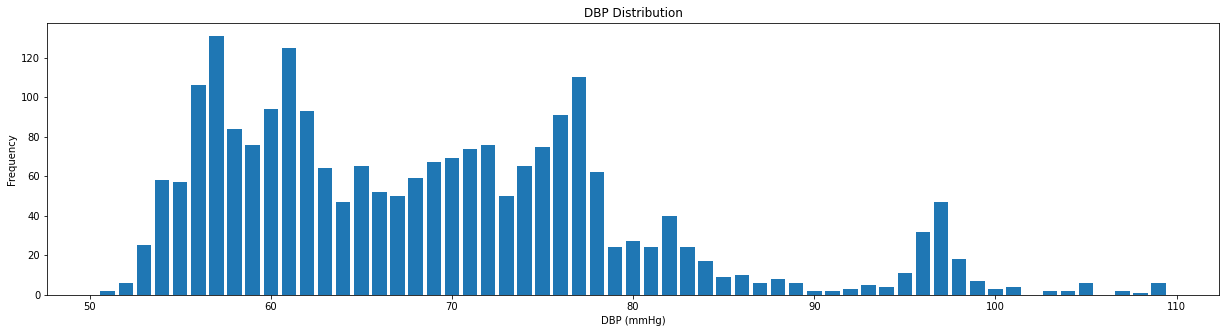

In [151]:
unique, frequency = np.unique(np.round(input_data[:, 6]).astype(int), 
                              return_counts = True) 
  
count = np.asarray((unique,frequency )).T

f1 = plt.figure()
f1.set_figwidth(21)
f1.set_figheight(5)
plt.bar(unique, frequency)
plt.title('DBP Distribution')
plt.xlabel('DBP (mmHg)')
plt.ylabel('Frequency')
plt.show

In [ ]:
columns = ['energy', 'Systolic Peak PPG Sample', 'Diastolic Peak PPG Sample', 'Systolic Peak PPG', 'Diastolic Peak PPG', 'SBP', 'DBP']
input_data_df = pd.DataFrame(data=input_data, columns=columns)
input_data_df

,energy,Systolic Peak PPG Sample,Diastolic Peak PPG Sample,Systolic Peak PPG,Diastolic Peak PPG,SBP,DBP
0,0.015121,61.0,61.0,0.788992,0.390858,125.360001,69.163002
1,0.015006,61.0,61.0,0.793518,0.394609,127.830002,71.068001
2,0.015113,61.0,61.0,0.793148,0.418692,127.190002,69.749001
3,0.015127,62.0,62.0,0.796026,0.393158,129.025002,70.042000
4,0.015157,62.0,62.0,0.798991,0.394275,128.190002,69.554001
...,...,...,...,...,...,...,...
2280,0.012037,82.0,82.0,0.780461,0.249079,90.761997,68.283997
2281,0.012167,80.0,80.5,0.766047,0.271916,143.454994,59.609001
2282,0.012262,80.5,80.0,0.770281,0.258213,148.759995,93.136002
2283,0.012059,80.5,81.0,0.761847,0.258088,151.690002,95.305000


In [ ]:
input_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2285 entries, 0 to 2284
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   energy                     2285 non-null   float64
 1   Systolic Peak PPG Sample   2285 non-null   float64
 2   Diastolic Peak PPG Sample  2285 non-null   float64
 3   Systolic Peak PPG          2285 non-null   float64
 4   Diastolic Peak PPG         2285 non-null   float64
 5   SBP                        2285 non-null   float64
 6   DBP                        2285 non-null   float64
dtypes: float64(7)
memory usage: 125.1 KB


**Data splitting**

In [ ]:
x_tosplit = input_data_df[['energy', 'Systolic Peak PPG Sample', 'Diastolic Peak PPG Sample', 'Systolic Peak PPG', 'Diastolic Peak PPG']]
y_tosplit = input_data_df[['SBP', 'DBP']]

X_train, X_test, y_train, y_test = train_test_split(
    x_tosplit, y_tosplit, test_size=0.1, random_state=0)

In [ ]:
X_train_org = X_train.to_numpy()
y_train_org = y_train.to_numpy()

X_test_org = X_test.to_numpy()
y_test_org = y_test.to_numpy()

Y_train_SBP_org = y_train_org[:, 0]
Y_train_DBP_org = y_train_org[:, 1]
Y_test_SBP_org = y_test_org[:, 0]
Y_test_DBP_org = y_test_org[:, 1]

In [ ]:
# standardize input data
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [ ]:
X_train_st.shape

(2056, 5)

In [ ]:
# scaled_df = input_data_df.copy()
# training_size = int(len(scaled_df) * 0.9)
# training, testing = scaled_df[0:training_size], scaled_df[training_size:len(data_featured_arr_tp_df)]

**Input feature shaping**

In [171]:
time_steps = 1
X_train_st_reshape = np.reshape(X_train_st, (X_train_st.shape[0], time_steps, X_train_st.shape[1]))
X_test_st_reshape = np.reshape(X_test_st, (X_test_st.shape[0], time_steps, X_test_st.shape[1]))

**Model Building**

In [119]:
metric = 'mae'
optim = 'adam'
def create_model_Bi(dense1, dense2, dense3, lstm1, lstm2, lstm3, dropout = 0.2):
  print("### creating model")
  model = keras.Sequential()
  # Adding a Bidirectional LSTM layer
  model.add(keras.Input(shape = (X_train_st_reshape.shape[1], X_train_st_reshape.shape[-1])))
  if dense1:
    model.add(Dense(dense1))
  if lstm1:
    model.add(Bidirectional(LSTM(lstm1, return_sequences=bool(lstm2))))
    model.add(Dropout(dropout))
  if lstm2:
    model.add(Bidirectional(LSTM(lstm2, return_sequences=bool(lstm3))))
    model.add(Dropout(dropout))
  if lstm3:
    model.add(Bidirectional(LSTM(lstm3)))
    model.add(Dropout(dropout))
  if dense2:
    model.add(Dense(dense2, activation='relu'))
  if dense3:
    model.add(Dense(dense3, activation='relu'))

  model.add(Dense(1))

  model.compile(loss='mae', optimizer='adam')
  model.summary()
  return model

**SBP**

In [132]:
epochs = 500
dense1 = None
dense2 = None
dense3 = None
lstm1 = 256
lstm2 = 256
lstm3 = 256

model = create_model_Bi(dense1, dense2, dense3, lstm1, lstm2, lstm3, dropout = 0.2)

history = model.fit(X_train_st_reshape, Y_train_SBP_org, epochs=epochs)
# history = model.fit(X_train_reshape, Y_train_SBP_arr, epochs=epochs, validation_split=0.3, callbacks=[early_stopping], verbose=1)


### creating model
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_66 (Bidirecti  (None, 1, 512)           536576    
 onal)                                                           
                                                                 
 dropout_66 (Dropout)        (None, 1, 512)            0         
                                                                 
 bidirectional_67 (Bidirecti  (None, 1, 512)           1574912   
 onal)                                                           
                                                                 
 dropout_67 (Dropout)        (None, 1, 512)            0         
                                                                 
 bidirectional_68 (Bidirecti  (None, 512)              1574912   
 onal)                                                           
                                  

In [89]:
# pred_SBP_train = model.predict(X_train_st_reshape)
# print(np.sqrt(mean_squared_error(Y_train_SBP_org, pred_SBP_train)))

# pred_SBP = model.predict(X_test_st_reshape)
# print(np.sqrt(mean_squared_error(Y_test_SBP_org, pred_SBP)))

In [133]:
# model = tf.keras.models.load_model(working_dir + 'Result/3_32/model_sgd_w1250_o625_e500_mae60660.h5')

pred_SBP_train = model.predict(X_train_st_reshape)
print(mean_absolute_error(Y_train_SBP_org, pred_SBP_train))

pred_SBP = model.predict(X_test_st_reshape)
print(mean_absolute_error(Y_test_SBP_org, pred_SBP))

2.5063318760942392
4.19736209186404


In [134]:
eval_metrics = model.evaluate(X_test_st_reshape, Y_test_SBP_org)
model_file_name = f'{working_dir}/Result_SBP/3_256/model_{optim}_w{window:04d}_o{overlap:03d}_e{epochs}_{metric}{round(eval_metrics * 10000)}'
model.save(model_file_name + '.h5')

8/8 [==============================] - 2s 13ms/step - loss: 4.1974


**DBP**

In [165]:
epochs = 500
dense1 = None
dense2 = None
dense3 = None
lstm1 = 256
lstm2 = 256
lstm3 = 256

model2 = create_model_Bi(dense1, dense2, dense3, lstm1, lstm2, lstm3, dropout = 0.2)

history2 = model2.fit(X_train_st_reshape, Y_train_DBP_org, epochs=epochs)
# history = model.fit(X_train_reshape, Y_train_SBP_arr, epochs=epochs, validation_split=0.3, callbacks=[early_stopping], verbose=1)

### creating model
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_69 (Bidirecti  (None, 1, 512)           536576    
 onal)                                                           
                                                                 
 dropout_69 (Dropout)        (None, 1, 512)            0         
                                                                 
 bidirectional_70 (Bidirecti  (None, 1, 512)           1574912   
 onal)                                                           
                                                                 
 dropout_70 (Dropout)        (None, 1, 512)            0         
                                                                 
 bidirectional_71 (Bidirecti  (None, 512)              1574912   
 onal)                                                           
                                  

In [166]:
pred_DBP_train = model2.predict(X_train_st_reshape)
print(mean_absolute_error(Y_train_DBP_org, pred_DBP_train))

pred_DBP = model2.predict(X_test_st_reshape)
print(mean_absolute_error(Y_test_DBP_org, pred_DBP))

1.3516292599852446
2.3063253794174527


In [167]:
eval_metrics2 = model2.evaluate(X_test_st_reshape, Y_test_DBP_org)
model_file_name2 = f'{working_dir}/Result_DBP/3_256/model_{optim}_w{window:04d}_o{overlap:03d}_e{epochs}_{metric}{round(eval_metrics2 * 10000)}'
model2.save(model_file_name2 + '.h5')

8/8 [==============================] - 2s 13ms/step - loss: 2.3063


**Result Visualization**

**SBP**

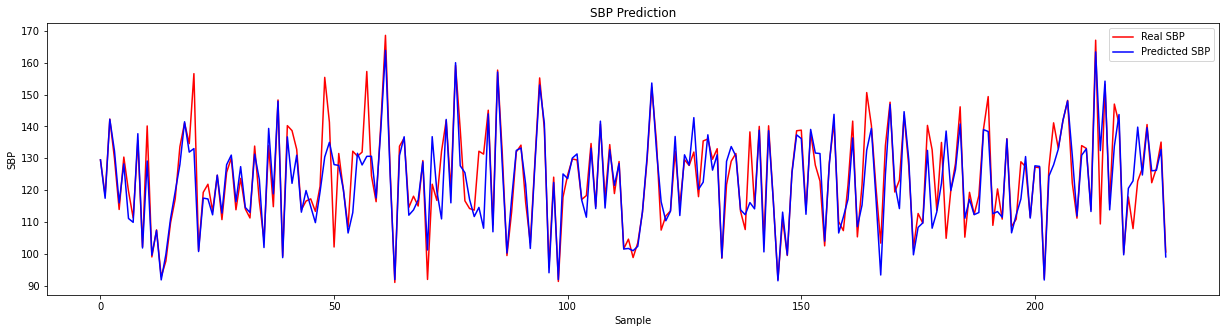

In [135]:
Y_test_SBP_st_reshape = np.reshape(Y_test_SBP_org, (-1, 1))
# pred_SBP_inv = standard_scaler.inverse_transform(pred_SBP)

# plot the results
f = plt.figure()
f.set_figwidth(21)
f.set_figheight(5)
plt.plot(Y_test_SBP_st_reshape, color = 'red', label = 'Real SBP')
plt.plot(pred_SBP, color = 'blue', label = 'Predicted SBP')
plt.title('SBP Prediction')
plt.xlabel('Sample')
plt.ylabel('SBP')
plt.legend()
plt.show()

In [158]:
# Correlation predicted and real value

pred_SBP_df = pd.Series(pred_SBP[:, 0])
Y_test_SBP_st_reshape_df = pd.Series(Y_test_SBP_st_reshape[:, 0])

correlation_SBP = pred_SBP_df.corr(Y_test_SBP_st_reshape_df)
correlation_SBP

0.8890735154930316

Text(0, 0.5, 'Predicted SBP (mmHg)')

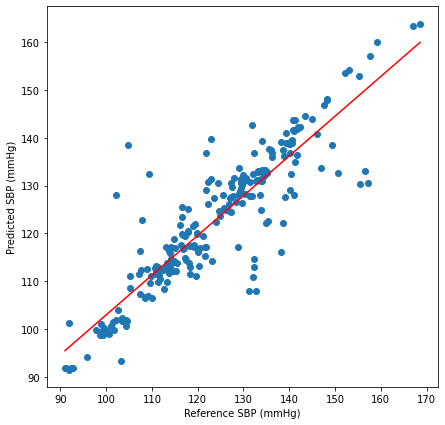

In [164]:
# plotting the data
f1 = plt.figure()
f1.set_figwidth(7)
f1.set_figheight(7)
plt.scatter(Y_test_SBP_st_reshape_df, pred_SBP_df)
  
# This will fit the best line into the graph
plt.plot(np.unique(Y_test_SBP_st_reshape_df), np.poly1d(np.polyfit(Y_test_SBP_st_reshape_df, pred_SBP_df, 1))
         (np.unique(Y_test_SBP_st_reshape_df)), color='red')
plt.xlabel('Reference SBP (mmHg)')
plt.ylabel('Predicted SBP (mmHg)')

**DBP**

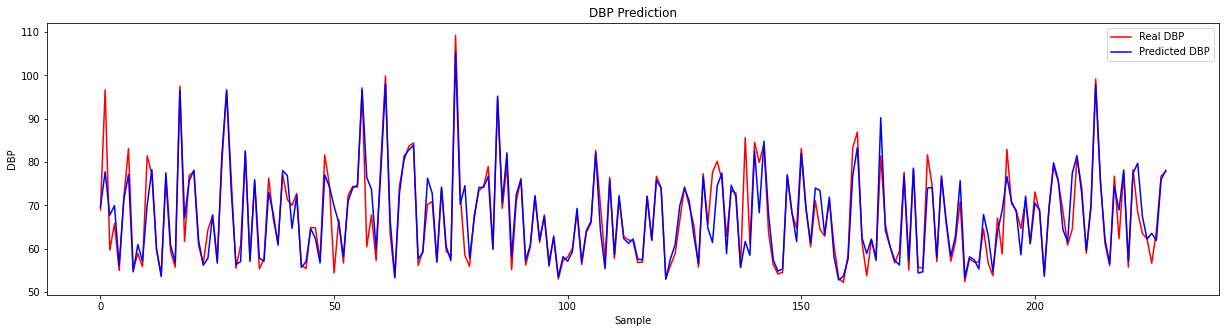

In [168]:
Y_test_DBP_st_reshape = np.reshape(Y_test_DBP_org, (-1, 1))
# pred_SBP_inv = standard_scaler.inverse_transform(pred_SBP)

# plot the results
f = plt.figure()
f.set_figwidth(21)
f.set_figheight(5)
plt.plot(Y_test_DBP_st_reshape, color = 'red', label = 'Real DBP')
plt.plot(pred_DBP, color = 'blue', label = 'Predicted DBP')
plt.title('DBP Prediction')
plt.xlabel('Sample')
plt.ylabel('DBP')
plt.legend()
plt.show()

In [169]:
# Correlation predicted and real value

pred_DBP_df = pd.Series(pred_DBP[:, 0])
Y_test_DBP_st_reshape_df = pd.Series(Y_test_DBP_st_reshape[:, 0])

correlation_DBP = pred_DBP_df.corr(Y_test_DBP_st_reshape_df)
correlation_DBP

0.9234389078166926

Text(0, 0.5, 'Predicted DBP (mmHg)')

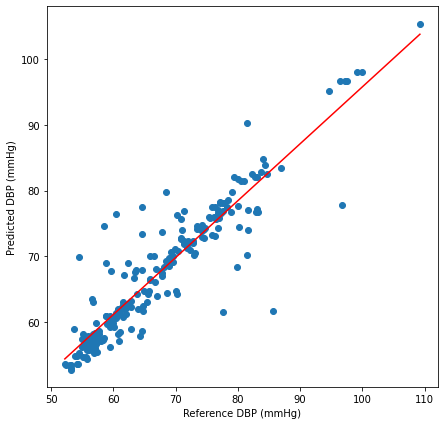

In [170]:
# plotting the data
f1 = plt.figure()
f1.set_figwidth(7)
f1.set_figheight(7)
plt.scatter(Y_test_DBP_st_reshape_df, pred_DBP_df)
  
# This will fit the best line into the graph
plt.plot(np.unique(Y_test_DBP_st_reshape_df), np.poly1d(np.polyfit(Y_test_DBP_st_reshape_df, pred_DBP_df, 1))
         (np.unique(Y_test_DBP_st_reshape_df)), color='red')
plt.xlabel('Reference DBP (mmHg)')
plt.ylabel('Predicted DBP (mmHg)')